In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

import seaborn as sns
sns.set(color_codes=True, style='white', context='talk', font_scale=1)
PALETTE = sns.color_palette("Set1")

from graspy.plot import pairplot
from lol import LOL
from hyppo.independence import Dcorr
from scipy.stats import multiscale_graphcorr
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

from nilearn import datasets, plotting
import nibabel as nib
import matplotlib as mpl

import sys; sys.path.append('../')
from src.tools.utils import get_files, get_latents

%load_ext autoreload
%autoreload 2

/home/rflperry/miniconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.mixture.gaussian_mixture module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.mixture. Anything that cannot be imported from sklearn.mixture is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
## Define paths
base_dir = Path("/mnt/ssd3/ronan/data/gcca_05-26-10:39_min_rank-ZG3/")
external_dir = Path('../data/external')
groups, labels = get_latents(base_dir, flag='_gcca')
print(labels)

[['e', 'restingstate'], ['e', 'openmonitoring'], ['e', 'compassion'], ['n', 'restingstate'], ['n', 'openmonitoring'], ['n', 'compassion']]


In [3]:
# plot on fsa5 surface:
fsa5 = datasets.fetch_surf_fsaverage()

In [4]:
def visualize_embeddings(
    embeddings,
    save_path=False,
    vmax=None,
    symmetric_cbar=True,
    colorbar=False,
    n_embed = 1,
    title = None,
):
    plt.clf()
    res_scale = 2
    fig, axes = plt.subplots(n_embed, 4, subplot_kw={'projection': '3d'}, figsize=(res_scale*5, res_scale*n_embed))
    if n_embed==1:
        axes = [axes]
    
    plt.subplots_adjust(wspace=0, hspace=0)        

    for i,ax in enumerate(axes):
        X = embeddings[:, i]

        cortex_left = nib.freesurfer.read_label(external_dir / 'lh.cortex.label')

        conn_map = np.zeros(10242)
        conn_map[cortex_left] = X[:len(cortex_left)]

        plotting.plot_surf_stat_map(fsa5.infl_left, 
          conn_map, hemi='left', colorbar=False, cmap='RdBu', axes = ax[0],
          vmax=vmax, symmetric_cbar=symmetric_cbar)

        plotting.plot_surf_stat_map(fsa5.infl_left,
          conn_map, hemi='left', colorbar=False, cmap='RdBu', view='medial', axes=ax[1], 
            vmax=vmax,symmetric_cbar=symmetric_cbar)

        cortex_right = nib.freesurfer.read_label(external_dir / 'rh.cortex.label')

        conn_map = np.zeros(10242)
        conn_map[cortex_right] = X[len(cortex_left):]

        plotting.plot_surf_stat_map(fsa5.infl_right, 
          conn_map, hemi='right', colorbar=False, cmap='RdBu', axes = ax[2], 
           vmax=vmax,symmetric_cbar=symmetric_cbar)

        plotting.plot_surf_stat_map(fsa5.infl_right,
          conn_map, hemi='right', colorbar=colorbar, cmap='RdBu', view='medial', axes=ax[3], 
            vmax=vmax,symmetric_cbar=symmetric_cbar)

    if title:
        fig.suptitle(title, fontsize=20, y=0.92)
    if save_path:
        plt.savefig(f'{str(save_path)}.png', format='png', bbox_inches='tight')
    else:
        return fig
#         plt.show()
#         plt.close(fig)
    
def make_cbar(vmax, save_path = None, vmin=None):
    if vmin is None:
        vmin = -vmax
        cmap = mpl.cm.RdBu
    else:
        cmap = mpl.cm.Blues
    fig, ax = plt.subplots(figsize=(1, 15))
    fig.subplots_adjust(bottom=0.5)

    #cmap = mpl.cm.RdBu
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                    norm=norm,
                                    orientation='vertical')
    
    #cb1.set_clim(vmin, vmax)
    #cb1.set_label('Some Units')
    if save_path:
        plt.savefig(f'{str(save_path)}.pdf', bbox_inches='tight')
    plt.close(fig)

In [5]:
save_dir = Path('../reports/paper_figures/')

In [23]:
diff_names = [
    "e-vs-n",
    "e_med-vs-n_rest",
]
diff_idxs = [
    [(0,1,2), (3,4,5)],
    [(1,2), (0,)],
]
diffs = []
for (idx1, idx2) in diff_idxs:
    g1 = [groups[i] for i in idx1]
    g2 = [groups[i] for i in idx2]
    n1 = np.sum(len(g) for g in g1)
    n2 = np.sum(len(g) for g in g2)
    std1 = np.vstack(g1).std(0)
    std2 = np.vstack(g2).std(0)
    diff = np.vstack(g1).mean(0) - np.vstack(g2).mean(0)
    ## account for bias
    diff = diff / (n1/(n1+n2-2)*std1**2 + n2/(n1+n2-2)*std2**2)
    diffs.append(diff)

/home/rflperry/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  del sys.path[0]
/home/rflperry/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


<Figure size 432x288 with 0 Axes>

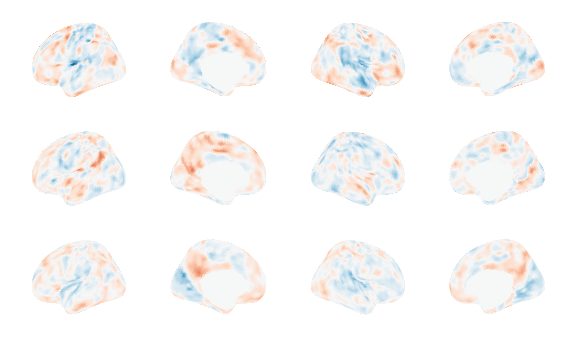

<Figure size 432x288 with 0 Axes>

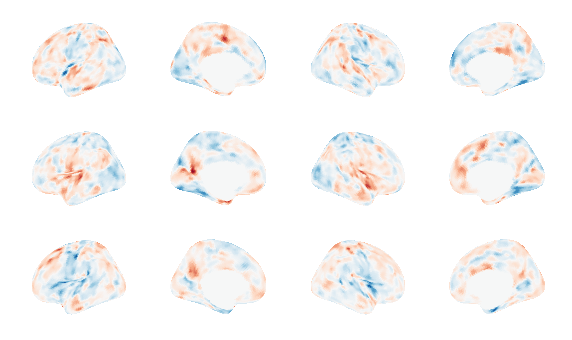

In [28]:
vmax = max([np.max(np.abs(g)) for g in diffs])
SAVE = True
COLORBAR = False

for name, diff in zip(diff_names, diffs):
    if COLORBAR:
        vmax = np.max(np.abs(diff))
    if SAVE:
        title = False
    else:
        title = name
    visualize_embeddings(
        diff,
        save_path=False,
        colorbar=COLORBAR,
        n_embed=3,
        vmax=vmax,
        title=title,
    )

    if SAVE:
        plt.savefig(save_dir / f'{name}_sig_diff_gradients.pdf', bbox_inches='tight')
        plt.show()
    else:
        plt.show()

if SAVE and not COLORBAR:
    make_cbar(vmax, save_dir / 'sig_diffs_gradients_colorbar')